# Get 50 samples for MiniGPT-4 generation results

## Import Libraries

In [5]:
import os
import shutil
import pandas as pd
import nltk
import gensim
from tqdm.notebook import tqdm
# Deep learning packages
import torch
from sklearn.model_selection import train_test_split
from textaugment import Word2vec
from textaugment import Fasttext
from textaugment import Wordnet
from textaugment import Translate
from textaugment import Word2vec, Fasttext
from textaugment import Translate

# Visualization packages
import matplotlib.pyplot as plt
import seaborn

In [6]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /home/neemias/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/neemias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/neemias/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Load DataFrame

In [8]:
!ls ..

checkpoints  experiments  README.md  scripts  textaugment
data	     models	  run.sh     src      utils


In [9]:
df = pd.read_csv("../data/raw/image_caption_mini_GPT4.csv") # captioning data for miniGPT-4
# df = pd.read_csv("../data/raw/image_caption_blip.csv") # captioning data for Blip Large model
df.head()

,image_path,caption
0,/home/neemias/perceptsent/data/1BhIkrf3HWatQFG...,The image shows a group of people lined up out...
1,/home/neemias/perceptsent/data/15LVGeXllPyPe1j...,This is a black and white image of the inside ...
2,/home/neemias/perceptsent/data/17dUXoyKzr4fS9Q...,This is an image of a street scene with buildi...
3,/home/neemias/perceptsent/data/11_yZVpq48fA-jc...,This is an image of a car that has been wrecke...
4,/home/neemias/perceptsent/data/1jH7ZVa_ZAbqNTh...,This is an image of a person standing on the s...


In [10]:
df["id"] = df["image_path"].apply(lambda x: x.split('/')[-1].split('.')[0]) # for miniGPT4

In [11]:
df.shape

(4840, 3)

In [12]:
df.head()

,image_path,caption,id
0,/home/neemias/perceptsent/data/1BhIkrf3HWatQFG...,The image shows a group of people lined up out...,1BhIkrf3HWatQFG7KxJK7MZ1oWbUczaar
1,/home/neemias/perceptsent/data/15LVGeXllPyPe1j...,This is a black and white image of the inside ...,15LVGeXllPyPe1jicnPTPl6kbBYJ5lZh8
2,/home/neemias/perceptsent/data/17dUXoyKzr4fS9Q...,This is an image of a street scene with buildi...,17dUXoyKzr4fS9QF-y3HU2oscLMvA9qLd
3,/home/neemias/perceptsent/data/11_yZVpq48fA-jc...,This is an image of a car that has been wrecke...,11_yZVpq48fA-jchrZO_sTtUKQejXd-te
4,/home/neemias/perceptsent/data/1jH7ZVa_ZAbqNTh...,This is an image of a person standing on the s...,1jH7ZVa_ZAbqNTheP2gTN5WOLI_NwkPwZ


In [13]:
model = gensim.models.KeyedVectors.load_word2vec_format('../models/GoogleNews-vectors-negative300.bin.gz', binary=True)

In [14]:
import json

f = open("../data/raw/dataset.json")
 
# returns JSON object as 
# a dictionary
data = json.load(f)

f.close()

In [15]:
sentiment_dict = {
    "SlightlyNegative": "Negative",
    "SlightlyPositive": "Positive",
    "Neutral": "Neutral",
    "Positive": "Positive",
    "Negative": "Negative"
}

In [16]:
images_flag = {}
perceptions_list = []
id_list = []
sentiments = []
texts = []
for name in df["id"].to_list():
    images_flag[name] = False

same = 0
other_sentiment = None
non = 0
for images in data["tasks"]:
    for image in  images["images"]:
        id = image["id"]
        in_out_door = image["in_out_door"]
        sentiment = sentiment_dict[image["sentiment"]]
        perceptions = image["perceptions"]
        
        if (id in images_flag and images_flag[id] == False):
            if (non/(non+same+1) > 0.5):
                sentiments[-1] = "Neutral"

            text = df[df["id"] == id]["caption"].iloc[0] # for miniGPT-4
            # text = df[df["id"] == id]["text"].iloc[0] # for blip
            images_flag[id] = True
            perceptions_list.append(str(perceptions))
            id_list.append(id)
            sentiments.append(sentiment)
            texts.append(text)
            same = 0
            non = 0
        elif (id in images_flag and images_flag[id] == True):
            if(perceptions[-1] == sentiment):
                same += 1
            else:
                non += 1




In [17]:
df_labeld = pd.DataFrame({"id": id_list, "perceptions": perceptions_list, "sentiment": sentiments, "text": texts})
df_labeld

,id,perceptions,sentiment,text
0,12hkDdykJDxOqYFTm7GfETe7MXHf5BTFa,['Everyday image'],Neutral,This is a picture of a power generator mounted...
1,1zOWYD7pM4OVTBnrJRI_hiDNkabTBF6DB,"['Accident', 'Debris/Destruction', 'Violence']",Negative,This is an image of a garbage truck driving do...
2,1p6jTOImdTHP8S6OtaiSY38tla3B-m9dH,['Everyday image'],Neutral,"The image is a photograph of a large, modern b..."
3,1oUgHvESxCf6ePsXKQO136BBKvhOXmRe8,"['Pleasant environment', 'Nature']",Positive,The image depicts a river flowing through a gr...
4,1ElLZwSILmCexeFYtb9Ldtl7qQcxx2_9A,"['Accident', 'Debris/Destruction', 'Trash']",Negative,"This image shows the remains of an old, abando..."
...,...,...,...,...
4835,1ciVYHQadePUYslI9KBXanXUNpDIsLw1i,"['Lack of Maintenance', 'Bad weather', 'Confus...",Negative,This is an image of a train track that runs th...
4836,1EbRT4DCUf5FzGchfkjDQTyyyLP0q-ZBQ,"['Violence', 'Bad weather', 'Pollution']",Negative,The image shows a group of people standing in ...
4837,1ilEI1s-2rAFgbaizI_kxlALtowM8rbsa,"['Trash', 'Pollution', 'Meaningless']",Negative,The image shows a plastic bottle on the beach ...
4838,1SMsRFVW80QTUUXQwppTwwfrqyMW1IdUl,"['Pleasant environment', 'Nature', 'Art/Archit...",Positive,This image shows a person standing on the bank...


## Analyze the Target Distribution

In [18]:
def plot_sentiment_distribution(df):
    """"
    Plots the distribution of sentiments
    Parameters:
        df(dataframe): DataFrame containing the "sentiment" column.

    Returns:
        None
    """

    sentiment_counts = df["sentiment"].value_counts()

    plt.figure(figsize=(6, 4))
    sentiment_counts.plot(kind="bar", color="skyblue")
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

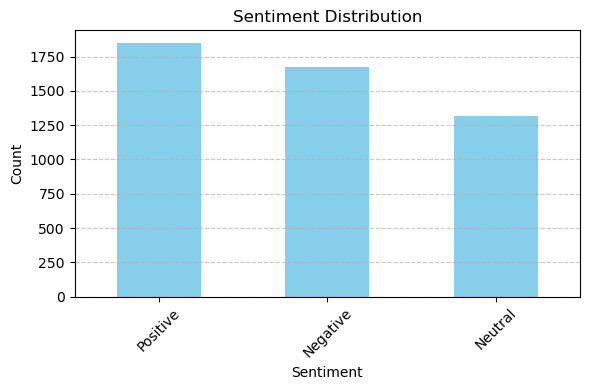

In [19]:
plot_sentiment_distribution(df_labeld)

## Train & Test Split

In [20]:
df_labeld.columns

Index(['id', 'perceptions', 'sentiment', 'text'], dtype='object')

In [21]:
df_labeld.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4840 entries, 0 to 4839
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           4840 non-null   object
 1   perceptions  4840 non-null   object
 2   sentiment    4840 non-null   object
 3   text         4840 non-null   object
dtypes: object(4)
memory usage: 151.4+ KB


In [22]:
sent_dict = {"Neutral": 1, "Negative": 0, "Positive": 2}
df_labeld["sentiment"] = df_labeld["sentiment"].apply(lambda x: sent_dict[x])

In [23]:
train_df, val_df = train_test_split(df_labeld[["text", "sentiment"]], test_size=0.3, random_state=42)
# train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)

print(f"Train size: {train_df.shape} | Validation size: {val_df.shape}")# | Test size: {test_df.shape}")

Train size: (3388, 2) | Validation size: (1452, 2)


In [24]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3388 entries, 2476 to 860
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       3388 non-null   object
 1   sentiment  3388 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 79.4+ KB


In [25]:
def data_augmentation(data, src="en", to="fr"):
    aug_sent = []
    aug_text = []
    for sentiment, text in tqdm(zip(data.sentiment.to_list(), data.text.to_list()), total=len(data), desc="Data augmentation progress"):
        t1 = Translate(src="en", to="fr")
        t2 = Word2vec(model=model)
        aug_text1 = t1.augment(text)
        aug_text2 = t2.augment(text)
        aug_sent.append(sentiment)
        aug_text.append(text)
        aug_sent.append(sentiment)
        aug_text.append(aug_text1)
        aug_sent.append(sentiment)
        aug_text.append(aug_text2)

    aug_data = pd.DataFrame({"sentiment": aug_sent, "text": aug_text})
    return aug_data

In [26]:
aug_train_df = data_augmentation(train_df)

aug_train_df.head()

Data augmentation progress:   0%|          | 0/3388 [00:00<?, ?it/s]

,sentiment,text
0,2,The image shows a person standing on a wooden ...
1,2,the image shows a person standing on a wooden ...
2,2,the imagery showing a man standing on a intric...
3,0,The image shows a group of men standing on a b...
4,0,the image shows a group of men standing on a b...


In [28]:
aug_train_df.shape

(10164, 2)

## Save DataFrames

In [17]:
train_df.to_csv("../data/train/train.csv", index=False)
aug_train_df.to_csv("../data/train/aug_train.csv", index=False)
val_df.to_csv("../data/validation/val.csv", index=False)
# test_df.to_csv("../data/test/test.csv", index=False)